2025-09-24 08:26:48.995232: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 08:26:49.056532: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 08:26:51.067629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 08:27:01.938413: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Step 1/7: Dosing summary …


dosing:   0%|          | 0/48 [00:00<?, ?it/s]

Step 2/7: Building PD sequences …


sequences:   0%|          | 0/48 [00:00<?, ?it/s]

Built sequences: N=48  T=24  F=3


2025-09-24 08:27:06.042667: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-09-24 08:27:11.394140: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


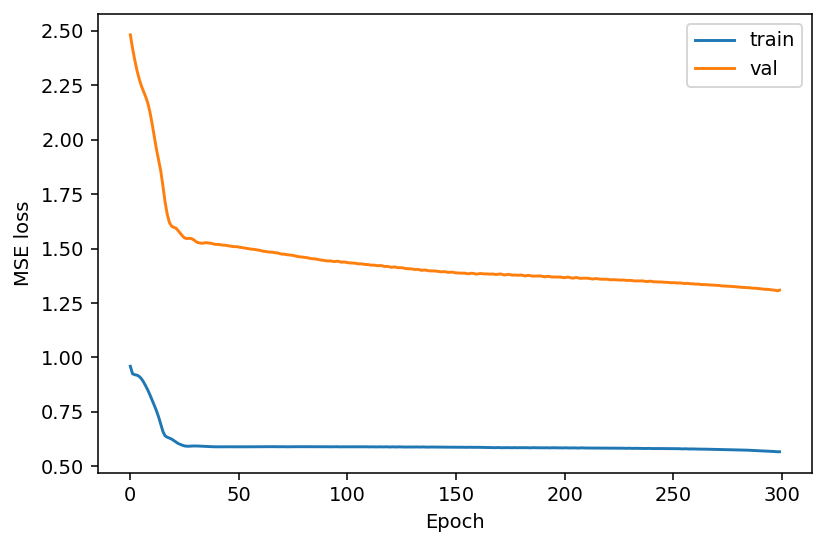

Saved: lstm_loss_curve.png
Step 7/7: Scanning doses (0.5 mg grid) …


dose grid:   0%|          | 0/200 [00:00<?, ?it/s]

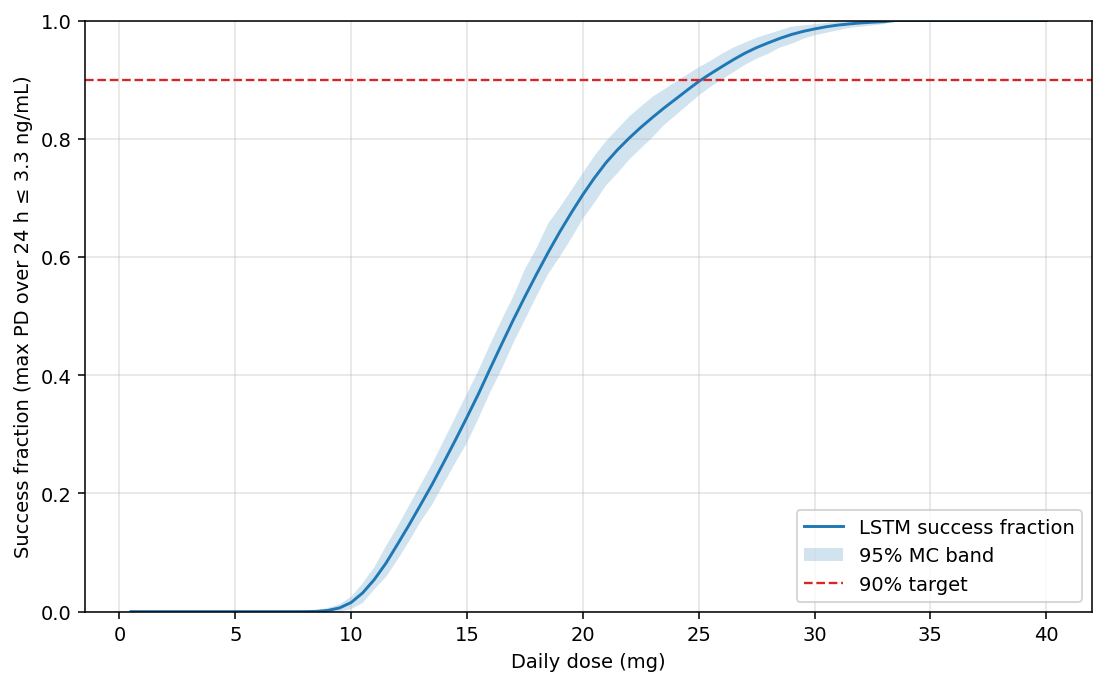

Minimal dose for 90% success (mean): 25.3 mg  |  95% CI: [24.5, 26.0] mg
Saved: lstm_loss_curve.png, lstm_dose_success.png and lstm_dose_success_summary.csv


In [3]:
# -*- coding: utf-8 -*-
# LSTM PK→PD (data-driven) + Monte-Carlo dose scan with proper units & inverse-scaling
import os, math, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.get_logger().setLevel("ERROR")  # quiet TF
from tensorflow.keras import layers, callbacks, models

# ---------------- Config ----------------
STRICT_THRESHOLD = 3.3          # ng/mL success threshold (applied AFTER inverse-scaling)
TAU_H            = 24.0
GRID_MAX         = 40.0
DOSE_STEP        = 0.5
VAL_SPLIT        = 0.2
SEED             = 42

K_EXPAND         = 10           # MC expansion
R_MC             = 200          # MC replicates for error bars (raise later)
SIGMA_BW         = 0.10         # log-normal jitter on BW
BW_CLIP          = (35.0, 120.0)

rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------- Load raw & light-clean -------------
def load_raw():
    df = pd.read_csv("EstData.csv")
    for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"])
    df = df[df["TIME"] >= 0].sort_values(["ID","TIME"]).reset_index(drop=True)
    return df

df = load_raw()
obs = df[(df["EVID"]==0) & (df["MDV"]==0)].copy()
pk  = obs[obs["DVID"]==1].copy()
pd_df = obs[obs["DVID"]==2].copy()

# -------- per-subject dosing summary --------
def infer_schedule(s):
    d = s[s["EVID"]==1]
    if len(d):
        dose = float(d["AMT"].median()) if d["AMT"].notna().any() else float(s["DOSE"].replace(0,np.nan).median())
        t = np.sort(d["TIME"].dropna().unique())
        tau = float(np.median(np.diff(t))) if len(t) >= 2 else TAU_H
    else:
        dose = float(s["DOSE"].replace(0,np.nan).median()); tau = TAU_H
    if not np.isfinite(dose): dose = 0.0
    return dose, tau

rows = []
print("Step 1/7: Dosing summary …")
for sid, s in tqdm(df.groupby("ID"), total=df["ID"].nunique(), leave=False, desc="dosing"):
    bw = float(s["BW"].dropna().iloc[0]) if s["BW"].notna().any() else np.nan
    comed = int(s["COMED"].dropna().iloc[0]) if s["COMED"].notna().any() else 0
    dose, tau = infer_schedule(s)
    rows.append({"ID":int(sid), "BW":bw, "COMED":comed, "DOSE_MG":dose, "INTERVAL_H":tau})
dose_tbl = pd.DataFrame(rows)

# -------- build 24h PD sequences (supervised PD prediction) --------
def last_window(s, tau, min_points=3, max_expand=8.0):
    if s.empty: return s.iloc[0:0].copy()
    tmax = float(s["TIME"].max()); best, bestn = s.iloc[0:0].copy(), 0; f=1.0
    while f <= max_expand:
        w = s[(s["TIME"]>=tmax-tau*f) & (s["TIME"]<=tmax)]
        if len(w)>bestn: best, bestn = w.copy(), len(w)
        if len(w) >= min_points: return w.sort_values("TIME")
        f *= 1.5
    return best.sort_values("TIME")

T = 24  # 24 time steps across the interval (hourly target grid)
times_grid = np.linspace(0, TAU_H, T)

def resample_to_grid(time, value, grid):
    if len(time)==0: return np.full_like(grid, np.nan, float)
    # ensure increasing
    ix = np.argsort(time)
    t, v = np.asarray(time)[ix], np.asarray(value)[ix]
    return np.interp(grid, t - t.min(), v, left=np.nan, right=np.nan)

print("Step 2/7: Building PD sequences …")
seq_X, seq_y, seq_ids, meta = [], [], [], []
for sid, s in tqdm(pd_df.groupby("ID"), total=pd_df["ID"].nunique(), leave=False, desc="sequences"):
    drow = dose_tbl.loc[dose_tbl["ID"]==sid]
    if drow.empty: continue
    tau = float(drow["INTERVAL_H"].iloc[0]) if np.isfinite(drow["INTERVAL_H"].iloc[0]) else TAU_H
    w = last_window(s.sort_values("TIME"), tau, min_points=3, max_expand=8.0)
    if w.empty: continue

    # resample PD to 24 hourly points
    t = w["TIME"].values.astype(float)
    v = w["DV"].values.astype(float)  # ng/mL
    vg = resample_to_grid(t, v, times_grid)
    if np.isnan(vg).all(): continue
    # simple forward-fill for any leading NaNs
    if np.isnan(vg[0]): 
        first = np.nanmin(np.where(~np.isnan(vg))[0], initial=None)
        if first is None: continue
        vg[:first] = vg[first]
    # linear fill remaining nans
    nmask = np.isnan(vg)
    if nmask.any():
        vg[nmask] = np.interp(np.where(nmask)[0], np.where(~nmask)[0], vg[~nmask])

    # features per time step: [time_norm, dose_mgkg, COMED]
    bw = float(drow["BW"].iloc[0]) if np.isfinite(drow["BW"].iloc[0]) else np.nan
    comed = int(drow["COMED"].iloc[0]) if np.isfinite(drow["COMED"].iloc[0]) else 0
    dose = float(drow["DOSE_MG"].iloc[0]) if np.isfinite(drow["DOSE_MG"].iloc[0]) else 0.0
    dose_mgkg = dose / bw if (np.isfinite(bw) and bw>0) else 0.0

    X_i = np.column_stack([
        times_grid / TAU_H,                       # time in [0,1]
        np.full(T, dose_mgkg, float),             # mg/kg (constant over t for qd)
        np.full(T, comed, int)                    # comed flag
    ])
    seq_X.append(X_i)
    seq_y.append(vg)   # PD in ng/mL (we'll standardize later)
    seq_ids.append(int(sid))
    meta.append((bw, comed))

X = np.asarray(seq_X, float)           # (N, T, F=3)
y = np.asarray(seq_y, float)           # (N, T)
ids = np.asarray(seq_ids, int)
meta = np.asarray(meta, float)         # columns: BW, COMED

print(f"Built sequences: N={len(X)}  T={T}  F={X.shape[2]}")

# -------- Train/val split (robust) & scaling --------
X, y, ids, meta = shuffle(X, y, ids, meta, random_state=SEED)

# Standardize target PD across TRAIN only (store for inverse-transform)
X_tr, X_va, y_tr, y_va, meta_tr, meta_va = train_test_split(
    X, y, meta, test_size=VAL_SPLIT, random_state=SEED
)

y_scaler = StandardScaler(with_mean=True, with_std=True)
y_tr_z = y_scaler.fit_transform(y_tr.reshape(-1, 1)).reshape(y_tr.shape)
y_va_z = y_scaler.transform(y_va.reshape(-1, 1)).reshape(y_va.shape)

# Optional: scale only the time channel (index 0); leave mg/kg and comed as-is
time_scaler = StandardScaler()
X_tr_scaled = X_tr.copy(); X_va_scaled = X_va.copy()
X_tr_scaled[...,0] = time_scaler.fit_transform(X_tr[...,0])
X_va_scaled[...,0] = time_scaler.transform(X_va[...,0])

# -------- LSTM model --------
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(T, X.shape[2])),
    layers.Masking(mask_value=0.0),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(32, activation="relu")),
    layers.TimeDistributed(layers.Dense(1))  # outputs PD in standardized z-space
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
es = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
hist = model.fit(
    X_tr_scaled, y_tr_z[..., None],
    validation_data=(X_va_scaled, y_va_z[..., None]),
    epochs=300, batch_size=16, verbose=0, callbacks=[es]
)

# -------- Loss curve --------
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend(); plt.tight_layout()
plt.savefig("lstm_loss_curve.png", dpi=160); plt.show()
print("Saved: lstm_loss_curve.png")

# -------- Utilities: predict PD(t) in ng/mL for a population at a given dose --------
def make_batch_for_dose(BW, COMED, dose_mg):
    """Return X_batch (N, T, F) for given population vectors BW, COMED at a dose."""
    N = len(BW)
    dose_mgkg = dose_mg / np.clip(BW, 1e-6, None)
    time_feat = np.tile(times_grid / TAU_H, (N,1))
    Xb = np.stack([
        time_feat,
        np.tile(dose_mgkg[:,None], (1,T)),
        np.tile(COMED[:,None], (1,T))
    ], axis=-1).astype(float)
    # scale time channel like training
    Xb[...,0] = time_scaler.transform(Xb[...,0])
    return Xb

def predict_pd_ngml(BW, COMED, dose_mg):
    """Return PD(t) in ng/mL for each subject (N,T)."""
    Xb = make_batch_for_dose(BW, COMED, dose_mg)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)  # (N,T) in z-space
    # inverse-scale to ng/mL
    yhat = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)
    return yhat

# -------- Base population (from TRAIN+VAL subjects) --------
BW_obs = meta[:,0]
COM_obs = meta[:,1]
BW_obs = BW_obs[np.isfinite(BW_obs)]
if BW_obs.size == 0: BW_obs = np.array([70.0])
p_comed = 0.5 if not np.isfinite(COM_obs).any() else float(np.nanmean(COM_obs))

# -------- Monte Carlo dose scan --------
dose_grid = np.arange(DOSE_STEP, GRID_MAX+DOSE_STEP, DOSE_STEP)
succ_mat = np.zeros((R_MC, len(dose_grid)))
dose90 = np.full(R_MC, np.nan)

print("Step 7/7: Scanning doses (0.5 mg grid) …")
for r in tqdm(range(R_MC), desc="dose grid"):
    # draw population
    N_base = len(BW_obs)
    base_idx = rng.integers(0, N_base, size=N_base*K_EXPAND)
    BW = BW_obs[base_idx] * np.exp(rng.normal(0.0, SIGMA_BW, size=N_base*K_EXPAND))
    BW = np.clip(BW, *BW_CLIP)
    COM = rng.binomial(1, p_comed, size=N_base*K_EXPAND)

    s = []
    for d in dose_grid:
        yhat = predict_pd_ngml(BW, COM, d)  # (N,T) in ng/mL
        ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # success if PD ≤ 3.3 for all t
        s.append(ok.mean())
    s = np.array(s)
    succ_mat[r,:] = s
    idx90 = np.where(s >= 0.90)[0]
    if idx90.size:
        dose90[r] = float(dose_grid[idx90[0]])

succ_mean = succ_mat.mean(axis=0)
succ_lo   = np.percentile(succ_mat, 2.5, axis=0)
succ_hi   = np.percentile(succ_mat,97.5, axis=0)

dose90_mean = float(np.nanmean(dose90)) if np.isfinite(dose90).any() else np.nan
dose90_ci   = (float(np.nanpercentile(dose90, 2.5)), float(np.nanpercentile(dose90,97.5))) if np.isfinite(dose90).any() else (np.nan, np.nan)

# -------- Plot dose → success --------
plt.figure(figsize=(8,5))
plt.plot(dose_grid, succ_mean, label="LSTM success fraction")
plt.fill_between(dose_grid, succ_lo, succ_hi, alpha=0.20, label="95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Daily dose (mg)")
plt.ylabel(f"Success fraction (max PD over 24 h ≤ {STRICT_THRESHOLD} ng/mL)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("lstm_dose_success.png", dpi=180); plt.show()

pd.DataFrame({"dose_mg":dose_grid, "succ_mean":succ_mean, "succ_lo2p5":succ_lo, "succ_hi97p5":succ_hi})\
  .to_csv("lstm_dose_success_summary.csv", index=False)

if np.isfinite(dose90_mean):
    print(f"Minimal dose for 90% success (mean): {dose90_mean:.1f} mg  |  95% CI: [{dose90_ci[0]:.1f}, {dose90_ci[1]:.1f}] mg")
else:
    print("No dose on the grid achieved ≥90% success.")
print("Saved: lstm_loss_curve.png, lstm_dose_success.png and lstm_dose_success_summary.csv")


Step 0/7: Loading data …
Step 1/7: Inferring per-subject dosing …


dosing:   0%|          | 0/48 [00:00<?, ?it/s]

Step 2/7: Building 24 h sequences …


sequences:   0%|          | 0/48 [00:00<?, ?it/s]

Built sequences: N=48  T=24  F=4
Step 3/7: Train/validation split + scaling …
Step 4/7: Training LSTM …
Epoch 1/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0936

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 578ms/step - loss: 1.0014 - val_loss: 2.4605 - learning_rate: 0.0010
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0317

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.9395 - val_loss: 2.2188 - learning_rate: 0.0010
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0360

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9393 - val_loss: 2.1488 - learning_rate: 0.0010
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.9275 - val_loss: 2.1713 - learning_rate: 0.0010
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.9084 - val_loss: 2.2099 - learning_rate: 0.0010
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.8945 - val_loss: 2.2137 - learning_rate: 0.0010
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.8835 - val_loss: 2.1665 - learning_rate: 0.0010
Epoch 8/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0989

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.8741 - val_loss: 2.0983 - learning_rate: 0.0010
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9361

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.8675 - val_loss: 2.0551 - learning_rate: 0.0010
Epoch 10/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.9643

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.8623 - val_loss: 2.0547 - learning_rate: 0.0010
Epoch 11/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8542 - val_loss: 2.0791 - learning_rate: 0.0010
Epoch 12/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8437 - val_loss: 2.0856 - learning_rate: 0.0010
Epoch 13/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9181

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.8320 - val_loss: 2.0504 - learning_rate: 0.0010
Epoch 14/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.9031

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.8198 - val_loss: 2.0051 - learning_rate: 0.0010
Epoch 15/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8593

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.8068 - val_loss: 1.9902 - learning_rate: 0.0010
Epoch 16/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8338

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.7879 - val_loss: 1.9774 - learning_rate: 0.0010
Epoch 17/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9006

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.7624 - val_loss: 1.9054 - learning_rate: 0.0010
Epoch 18/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7762

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.7326 - val_loss: 1.8232 - learning_rate: 0.0010
Epoch 19/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.7230

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.6983 - val_loss: 1.7669 - learning_rate: 0.0010
Epoch 20/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.6561

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.6579 - val_loss: 1.6574 - learning_rate: 0.0010
Epoch 21/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5947

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.6289 - val_loss: 1.5939 - learning_rate: 0.0010
Epoch 22/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.6225 - val_loss: 1.6114 - learning_rate: 0.0010
Epoch 23/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.5380

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.6344 - val_loss: 1.5865 - learning_rate: 0.0010
Epoch 24/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.5345

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.6310 - val_loss: 1.4953 - learning_rate: 0.0010
Epoch 25/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.6205 - val_loss: 1.6562 - learning_rate: 0.0010
Epoch 26/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.6147 - val_loss: 1.5181 - learning_rate: 0.0010
Epoch 27/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6110 - val_loss: 1.6514 - learning_rate: 0.0010
Epoch 28/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.6072 - val_loss: 1.5280 - learning_rate: 0.0010
Epoch 29/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.6013 - val_loss: 1.5652 - learning_rate: 0.0010
Epoch 30/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6001 - val_loss: 1.4994 - learning_rate: 0.0010
Epoch 31/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.5941 - val_loss: 1.5264 - learning_rate: 0.0010
Epoch 32/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5971 - val_loss: 1.5112 - learning_rate: 0.0010
Epoch 33/400
3/3 ━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.6008 - val_loss: 1.4465 - learning_rate: 0.0010
Epoch 39/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.5917 - val_loss: 1.5284 - learning_rate: 0.0010
Epoch 40/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5361

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.5967 - val_loss: 1.4367 - learning_rate: 0.0010
Epoch 41/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.5889 - val_loss: 1.5701 - learning_rate: 0.0010
Epoch 42/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5934 - val_loss: 1.4602 - learning_rate: 0.0010
Epoch 43/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5890 - val_loss: 1.5927 - learning_rate: 0.0010
Epoch 44/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5929 - val_loss: 1.4701 - learning_rate: 0.0010
Epoch 45/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.5896 - val_loss: 1.5860 - learning_rate: 0.0010
Epoch 46/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.5921 - val_loss: 1.4663 - learning_rate: 0.0010
Epoch 47/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5890 - val_loss: 1.5704 - learning_rate: 0.0010
Epoch 48/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.5912 - val_loss: 1.4672 - learning_rate: 0.0010
Epoch 49/400
3/3 ━━━━━━━━━━━━━

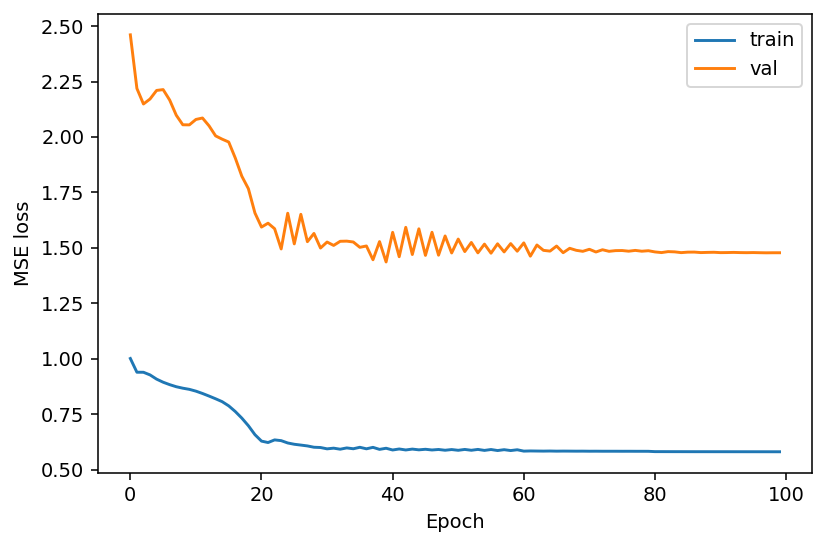

Saved: lstm_qw_loss_curve.png
Step 5/7: Preparing once-weekly simulator …
Step 6/7: Monte-Carlo weekly dose scan …


weekly dose grid:   0%|          | 0/200 [00:00<?, ?it/s]

Step 7/7: Plotting …


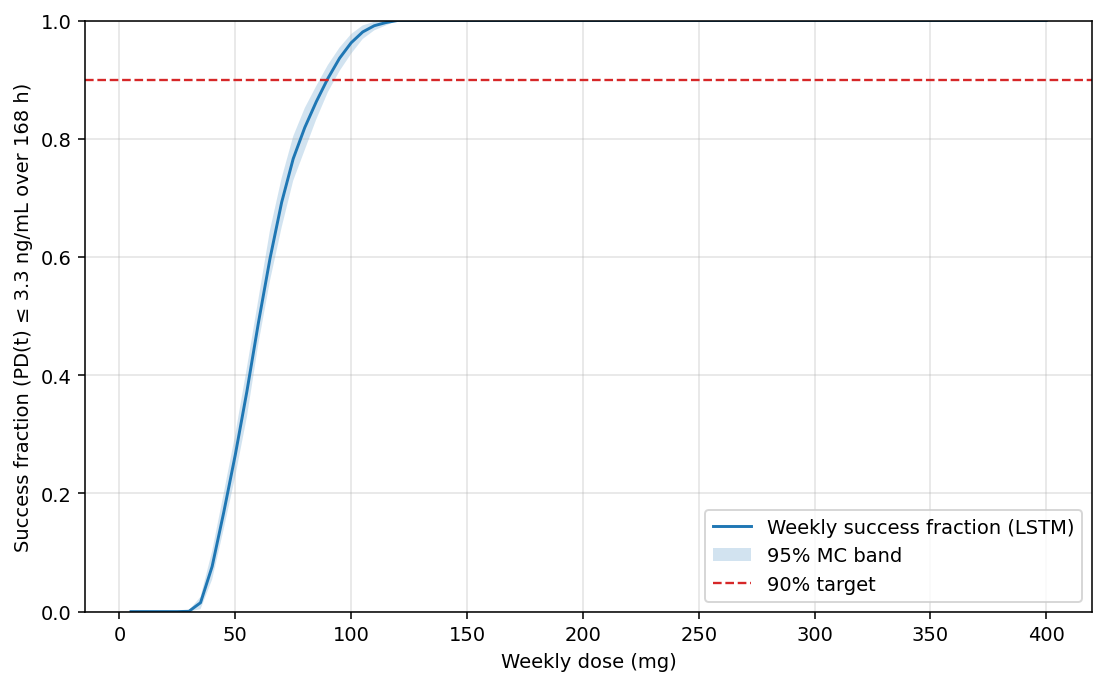

Minimal *weekly* dose for 90% success (mean): 92 mg  | 95% CI: [90, 95] mg
Saved: lstm_qw_loss_curve.png, lstm_weekly_dose_success.png, lstm_weekly_dose_success_summary.csv


In [11]:
# -*- coding: utf-8 -*-
# LSTM PD(t) model trained on 24 h, applied to once-weekly (168 h) dosing.
# Finds minimal weekly dose (5 mg steps) to reach ≥90% population success
# (PD(t) ≤ 3.3 ng/mL for all t in [0,168] at steady-state).

import os, math, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.keras import layers, callbacks, models

# ----------------------------- Config -----------------------------
STRICT_THRESHOLD = 3.3          # ng/mL success threshold
TAU_QD           = 24.0         # qd interval seen in training
TAU_QW           = 168.0        # target weekly interval
GRID_MAX_WEEKLY  = 400.0        # max weekly dose to scan (mg)
WEEKLY_STEP      = 5.0          # 5 mg steps
VAL_SPLIT        = 0.2
SEED             = 42

# Monte Carlo
K_EXPAND         = 10           # expand population ~10x
R_MC             = 200          # MC replicates (increase if you want tighter bands)
SIGMA_BW         = 0.10         # 10% log-normal jitter on BW
BW_CLIP          = (35.0, 120.0)

# ----------------------------- Training -----------------------------
EPOCHS = 400  # train up to 400 epochs

# If you want to ALWAYS run all 400, comment out EarlyStopping in callbacks_list
callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=60, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint("lstm_best.h5", monitor="val_loss", save_best_only=True, verbose=0),
]

rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------- Load & light-clean -----------------------
def load_raw():
    df = pd.read_csv("EstData.csv")
    for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"])
    df = df[df["TIME"] >= 0].sort_values(["ID","TIME"]).reset_index(drop=True)
    return df

print("Step 0/7: Loading data …")
df = load_raw()
obs = df[(df["EVID"]==0) & (df["MDV"]==0)].copy()
pk  = obs[obs["DVID"]==1].copy()
pd_df = obs[obs["DVID"]==2].copy()

# --------------------- Per-subject dosing ------------------------
def infer_schedule(s):
    d = s[s["EVID"]==1]
    if len(d):
        dose = float(d["AMT"].median()) if d["AMT"].notna().any() else float(s["DOSE"].replace(0,np.nan).median())
        t = np.sort(d["TIME"].dropna().unique())
        tau = float(np.median(np.diff(t))) if len(t) >= 2 else TAU_QD
    else:
        dose = float(s["DOSE"].replace(0,np.nan).median()); tau = TAU_QD
    if not np.isfinite(dose): dose = 0.0
    return dose, tau

rows = []
print("Step 1/7: Inferring per-subject dosing …")
for sid, s in tqdm(df.groupby("ID"), total=df["ID"].nunique(), leave=False, desc="dosing"):
    bw = float(s["BW"].dropna().iloc[0]) if s["BW"].notna().any() else np.nan
    comed = int(s["COMED"].dropna().iloc[0]) if s["COMED"].notna().any() else 0
    dose, tau = infer_schedule(s)
    rows.append({"ID":int(sid), "BW":bw, "COMED":comed, "DOSE_MG":dose, "INTERVAL_H":tau})
dose_tbl = pd.DataFrame(rows)

# ------------------ Build PD sequences (24 h) --------------------
def last_window(s, tau, min_points=3, max_expand=8.0):
    if s.empty: return s.iloc[0:0].copy()
    tmax = float(s["TIME"].max()); best, bestn = s.iloc[0:0].copy(), 0; f=1.0
    while f <= max_expand:
        w = s[(s["TIME"]>=tmax-tau*f) & (s["TIME"]<=tmax)]
        if len(w)>bestn: best, bestn = w.copy(), len(w)
        if len(w) >= min_points: return w.sort_values("TIME")
        f *= 1.5
    return best.sort_values("TIME")

def resample_to_grid(time, value, grid):
    if len(time)==0: return np.full_like(grid, np.nan, float)
    ix = np.argsort(time)
    t, v = np.asarray(time)[ix], np.asarray(value)[ix]
    return np.interp(grid, t - t.min(), v, left=np.nan, right=np.nan)

T = 24                                   # 24 points across the interval
grid_24h = np.linspace(0, TAU_QD, T)

print("Step 2/7: Building 24 h sequences …")
seq_X, seq_y, meta = [], [], []
for sid, s in tqdm(pd_df.groupby("ID"), total=pd_df["ID"].nunique(), leave=False, desc="sequences"):
    drow = dose_tbl.loc[dose_tbl["ID"]==sid]
    if drow.empty: continue
    tau = float(drow["INTERVAL_H"].iloc[0]) if np.isfinite(drow["INTERVAL_H"].iloc[0]) else TAU_QD
    w = last_window(s.sort_values("TIME"), tau, min_points=3, max_expand=8.0)
    if w.empty: continue

    t = w["TIME"].values.astype(float)
    v = w["DV"].values.astype(float)  # PD in ng/mL
    vg = resample_to_grid(t, v, grid_24h)
    if np.isnan(vg).all(): continue
    # forward-fill first NaNs, then linear-fill
    if np.isnan(vg[0]):
        first = np.nanmin(np.where(~np.isnan(vg))[0])
        vg[:first] = vg[first]
    nmask = np.isnan(vg)
    if nmask.any():
        vg[nmask] = np.interp(np.where(nmask)[0], np.where(~nmask)[0], vg[~nmask])

    bw = float(drow["BW"].iloc[0]) if np.isfinite(drow["BW"].iloc[0]) else np.nan
    comed = int(drow["COMED"].iloc[0]) if np.isfinite(drow["COMED"].iloc[0]) else 0
    dose = float(drow["DOSE_MG"].iloc[0]) if np.isfinite(drow["DOSE_MG"].iloc[0]) else 0.0
    dose_mgkg = dose / bw if (np.isfinite(bw) and bw>0) else 0.0

    # Features per step: [time_norm, dose_mgkg, comed, tau_norm]
    X_i = np.column_stack([
        grid_24h / TAU_QD,
        np.full(T, dose_mgkg, float),
        np.full(T, comed, int),
        np.full(T, 1.0, float)            # tau_norm = 24h/24h = 1 during training
    ])
    seq_X.append(X_i)
    seq_y.append(vg)
    meta.append((bw, comed))

X = np.asarray(seq_X, float)   # (N, T, 4)
y = np.asarray(seq_y, float)   # (N, T)
meta = np.asarray(meta, float) # (N, 2) -> [BW, COMED]

print(f"Built sequences: N={len(X)}  T={T}  F={X.shape[2]}")

# ---------------- Train/val split + scaling ----------------------
print("Step 3/7: Train/validation split + scaling …")
X, y, meta = shuffle(X, y, meta, random_state=SEED)

X_tr, X_va, y_tr, y_va, meta_tr, meta_va = train_test_split(
    X, y, meta, test_size=VAL_SPLIT, random_state=SEED
)

# Standardize PD target on TRAIN only, keep inverse-transform
y_scaler = StandardScaler()
y_tr_z = y_scaler.fit_transform(y_tr.reshape(-1,1)).reshape(y_tr.shape)
y_va_z = y_scaler.transform(y_va.reshape(-1,1)).reshape(y_va.shape)

# Standardize time feature only; keep dose_mgkg/comed/tau_norm as-is
time_scaler = StandardScaler()

X_tr_s = X_tr.copy()
X_va_s = X_va.copy()

t_tr_vec = X_tr[..., 0].reshape(-1, 1)              # (N*T, 1)
time_scaler.fit(t_tr_vec)

X_tr_s[..., 0] = time_scaler.transform(X_tr[..., 0].reshape(-1, 1)).reshape(X_tr[..., 0].shape)
X_va_s[..., 0] = time_scaler.transform(X_va[..., 0].reshape(-1, 1)).reshape(X_va[..., 0].shape)

# ----------------------- Build & train LSTM ----------------------
print("Step 4/7: Training LSTM …")
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(T, X.shape[2])),
    layers.Masking(mask_value=0.0),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(32, activation="relu")),
    layers.TimeDistributed(layers.Dense(1))  # PD in z-space
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0), loss="mse")

# train for up to EPOCHS (400). To ALWAYS run 400, remove EarlyStopping above.
hist = model.fit(
    X_tr_s, y_tr_z[...,None],
    validation_data=(X_va_s, y_va_z[...,None]),
    epochs=EPOCHS, batch_size=16, shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)

# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend(); plt.tight_layout()
plt.savefig("lstm_qw_loss_curve.png", dpi=160); plt.show()
print("Saved: lstm_qw_loss_curve.png")

# --------------------- Weekly simulator --------------------------
print("Step 5/7: Preparing once-weekly simulator …")

def make_weekly_batch(BW, COMED, dose_weekly_mg):
    N = len(BW)
    T168 = 168
    tgrid = np.linspace(0, TAU_QW, T168)
    dose_mgkg = dose_weekly_mg / np.clip(BW, 1e-6, None)

    Xb = np.stack([
        tgrid/TAU_QW * np.ones((N, T168)),      # time_norm (weekly)
        np.tile(dose_mgkg[:, None], (1, T168)), # mg/kg
        np.tile(COMED[:, None], (1, T168)),     # comed
        np.full((N, T168), TAU_QW/TAU_QD, float)# tau_norm = 7
    ], axis=-1).astype(float)

    # Scale time channel with the SAME scaler (fit on 24 h)
    Xb[..., 0] = time_scaler.transform(Xb[..., 0].reshape(-1, 1)).reshape(Xb[..., 0].shape)

    return Xb, tgrid

def predict_weekly_pd_ngml(BW, COMED, dose_weekly_mg):
    Xb, tgrid = make_weekly_batch(BW, COMED, dose_weekly_mg)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)         # (N, 168) z-space
    yhat = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)  # ng/mL
    return yhat, tgrid

# Base population from data:
BW_obs = meta[:,0]
COM_obs = meta[:,1]
BW_obs = BW_obs[np.isfinite(BW_obs)]
if BW_obs.size == 0: BW_obs = np.array([70.0])
p_comed = 0.5 if not np.isfinite(COM_obs).any() else float(np.nanmean(COM_obs))

# --------------------- MC scan (weekly) --------------------------
print("Step 6/7: Monte-Carlo weekly dose scan …")
dose_grid = np.arange(WEEKLY_STEP, GRID_MAX_WEEKLY+WEEKLY_STEP, WEEKLY_STEP)
succ_mat = np.zeros((R_MC, len(dose_grid)))
dose90 = np.full(R_MC, np.nan)

for r in tqdm(range(R_MC), desc="weekly dose grid"):
    # draw population ~10x base
    N_base = len(BW_obs)
    base_idx = rng.integers(0, N_base, size=N_base*K_EXPAND)
    BW = BW_obs[base_idx] * np.exp(rng.normal(0.0, SIGMA_BW, size=N_base*K_EXPAND))
    BW = np.clip(BW, *BW_CLIP)
    COM = rng.binomial(1, p_comed, size=N_base*K_EXPAND)

    s = []
    for d in dose_grid:
        yhat, _ = predict_weekly_pd_ngml(BW, COM, d)  # (N, 168) in ng/mL
        ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # success if PD ≤ 3.3 for all 168 h
        s.append(ok.mean())
    s = np.array(s)
    succ_mat[r,:] = s
    idx90 = np.where(s >= 0.90)[0]
    if idx90.size:
        dose90[r] = float(dose_grid[idx90[0]])

succ_mean = succ_mat.mean(axis=0)
succ_lo   = np.percentile(succ_mat, 2.5, axis=0)
succ_hi   = np.percentile(succ_mat,97.5, axis=0)

dose90_mean = float(np.nanmean(dose90)) if np.isfinite(dose90).any() else np.nan
dose90_ci   = (float(np.nanpercentile(dose90, 2.5)), float(np.nanpercentile(dose90,97.5))) if np.isfinite(dose90).any() else (np.nan, np.nan)

# --------------------- Plot & report -----------------------------
print("Step 7/7: Plotting …")
plt.figure(figsize=(8,5))
plt.plot(dose_grid, succ_mean, label="Weekly success fraction (LSTM)")
plt.fill_between(dose_grid, succ_lo, succ_hi, alpha=0.20, label="95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Weekly dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 168 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("lstm_weekly_dose_success.png", dpi=180); plt.show()

pd.DataFrame({"weekly_dose_mg":dose_grid,
              "succ_mean":succ_mean, "succ_lo2p5":succ_lo, "succ_hi97p5":succ_hi})\
  .to_csv("lstm_weekly_dose_success_summary.csv", index=False)

if np.isfinite(dose90_mean):
    print(f"Minimal *weekly* dose for 90% success (mean): {dose90_mean:.0f} mg  "
          f"| 95% CI: [{dose90_ci[0]:.0f}, {dose90_ci[1]:.0f}] mg")
else:
    print("No weekly dose on the grid achieved ≥90% success. Increase GRID_MAX_WEEKLY or review model fit.")

print("Saved: lstm_qw_loss_curve.png, lstm_weekly_dose_success.png, lstm_weekly_dose_success_summary.csv")


Step 0/7: Loading data …
Step 1/7: Inferring per-subject dosing …


dosing:   0%|          | 0/48 [00:00<?, ?it/s]

Step 2/7: Building 24 h sequences …


sequences:   0%|          | 0/48 [00:00<?, ?it/s]

Built sequences: N=48  T=24  F=4
Step 3/7: Train/validation split + scaling …
Step 4/7: Training LSTM …
Epoch 1/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.1557

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 569ms/step - loss: 1.0228 - val_loss: 2.5889 - learning_rate: 0.0010
Epoch 2/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.0960

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.9553 - val_loss: 2.3988 - learning_rate: 0.0010
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0609

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.9604 - val_loss: 2.3336 - learning_rate: 0.0010
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0514

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.9522 - val_loss: 2.3055 - learning_rate: 0.0010
Epoch 5/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2070

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.9339 - val_loss: 2.2987 - learning_rate: 0.0010
Epoch 6/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.0426

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.9168 - val_loss: 2.2776 - learning_rate: 0.0010
Epoch 7/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1.0186

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.9021 - val_loss: 2.2270 - learning_rate: 0.0010
Epoch 8/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0008

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.8897 - val_loss: 2.1711 - learning_rate: 0.0010
Epoch 9/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.9902

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.8815 - val_loss: 2.1339 - learning_rate: 0.0010
Epoch 10/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.9759

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.8716 - val_loss: 2.1157 - learning_rate: 0.0010
Epoch 11/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.9626

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.8622 - val_loss: 2.0968 - learning_rate: 0.0010
Epoch 12/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.9483

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.8517 - val_loss: 2.0781 - learning_rate: 0.0010
Epoch 13/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.9315

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.8398 - val_loss: 2.0571 - learning_rate: 0.0010
Epoch 14/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.9113

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.8255 - val_loss: 2.0237 - learning_rate: 0.0010
Epoch 15/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.8865

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.8079 - val_loss: 1.9842 - learning_rate: 0.0010
Epoch 16/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.8308

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.7852 - val_loss: 1.9413 - learning_rate: 0.0010
Epoch 17/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.7919

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.7559 - val_loss: 1.8803 - learning_rate: 0.0010
Epoch 18/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8216

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.7213 - val_loss: 1.8076 - learning_rate: 0.0010
Epoch 19/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.7409

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.6879 - val_loss: 1.7697 - learning_rate: 0.0010
Epoch 20/400
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6571

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.6671 - val_loss: 1.7126 - learning_rate: 0.0010
Epoch 21/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6341

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.6596 - val_loss: 1.6854 - learning_rate: 0.0010
Epoch 22/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6105

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.6482 - val_loss: 1.6313 - learning_rate: 0.0010
Epoch 23/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.5538

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6257 - val_loss: 1.5637 - learning_rate: 0.0010
Epoch 24/400
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5329

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.6136 - val_loss: 1.5417 - learning_rate: 0.0010
Epoch 25/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.6103 - val_loss: 1.5754 - learning_rate: 0.0010
Epoch 26/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6090 - val_loss: 1.5984 - learning_rate: 0.0010
Epoch 27/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5532

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.6044 - val_loss: 1.5206 - learning_rate: 0.0010
Epoch 28/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.6007 - val_loss: 1.5820 - learning_rate: 0.0010
Epoch 29/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.6011 - val_loss: 1.5622 - learning_rate: 0.0010
Epoch 30/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5470

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.5958 - val_loss: 1.4847 - learning_rate: 0.0010
Epoch 31/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5950 - val_loss: 1.5752 - learning_rate: 0.0010
Epoch 32/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5961 - val_loss: 1.5287 - learning_rate: 0.0010
Epoch 33/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5930 - val_loss: 1.5107 - learning_rate: 0.0010
Epoch 34/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5948 - val_loss: 1.5717 - learning_rate: 0.0010
Epoch 35/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.5946 - val_loss: 1.5364 - learning_rate: 0.0010
Epoch 36/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5946 - val_loss: 1.5558 - learning_rate: 0.0010
Epoch 37/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5959 - val_loss: 1.5587 - learning_rate: 0.0010
Epoch 38/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5938 - val_loss: 1.5221 - learning_rate: 0.0010
Epoch 39/400
3/3 ━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.5836 - val_loss: 1.4847 - learning_rate: 2.5000e-04
Epoch 72/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.5834 - val_loss: 1.4982 - learning_rate: 2.5000e-04
Epoch 73/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.5834 - val_loss: 1.5021 - learning_rate: 2.5000e-04
Epoch 74/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.5834 - val_loss: 1.4861 - learning_rate: 2.5000e-04
Epoch 75/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.5833 - val_loss: 1.4988 - learning_rate: 2.5000e-04
Epoch 76/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5833 - val_loss: 1.4956 - learning_rate: 2.5000e-04
Epoch 77/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5832 - val_loss: 1.4896 - learning_rate: 2.5000e-04
Epoch 78/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.5832 - val_loss: 1.4979 - learning_rate: 2.5000e-04
Epoch 79/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.5832 - val_loss: 1.4928 - learning_rate: 2.5000

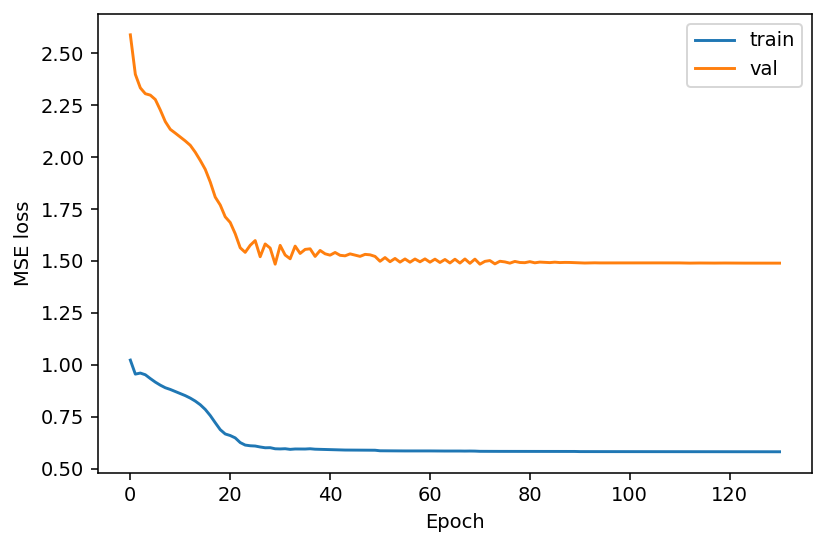

Saved: lstm_qw_loss_curve.png
Step 5/7: Preparing once-weekly simulator …
Step 6/7: Monte-Carlo weekly dose scan …


weekly dose grid:   0%|          | 0/200 [00:00<?, ?it/s]

Step 7/7: Plotting …


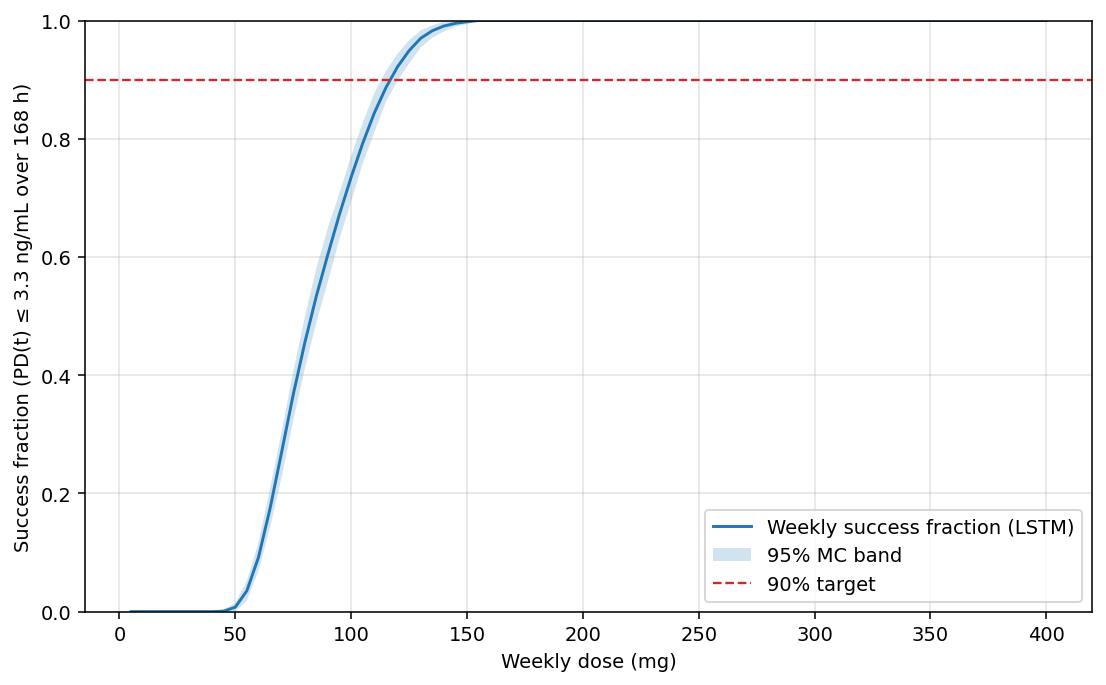

Minimal *weekly* dose for 90% success (mean): 119 mg  | 95% CI: [115, 125] mg
Saved: lstm_qw_loss_curve.png, lstm_weekly_dose_success.png, lstm_weekly_dose_success_summary.csv


In [12]:
# -*- coding: utf-8 -*-
# LSTM PD(t) model trained on 24 h, applied to once-weekly (168 h) dosing.
# Finds minimal weekly dose (5 mg steps) to reach ≥90% population success
# (PD(t) ≤ 3.3 ng/mL for all t in [0,168] at steady-state).

import os, math, warnings
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.keras import layers, callbacks, models

# ----------------------------- Config -----------------------------
STRICT_THRESHOLD = 3.3          # ng/mL success threshold
TAU_QD           = 24.0         # qd interval seen in training
TAU_QW           = 168.0        # target weekly interval
GRID_MAX_WEEKLY  = 400.0        # max weekly dose to scan (mg)
WEEKLY_STEP      = 5.0          # 5 mg steps
VAL_SPLIT        = 0.2
SEED             = 42

# Monte Carlo
K_EXPAND         = 10           # expand population ~10x
R_MC             = 200          # MC replicates (increase if you want tighter bands)
SIGMA_BW         = 0.10         # 10% log-normal jitter on BW
BW_CLIP          = (35.0, 120.0)

# ----------------------------- Training -----------------------------
EPOCHS = 400  # train up to 400 epochs

# If you want to ALWAYS run all 400, comment out EarlyStopping in callbacks_list
callbacks_list = [
    callbacks.EarlyStopping(monitor="val_loss", patience=60, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint("lstm_best.h5", monitor="val_loss", save_best_only=True, verbose=0),
]

rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------- Load & light-clean -----------------------
def load_raw():
    df = pd.read_csv("EstData.csv")
    for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"])
    df = df[df["TIME"] >= 0].sort_values(["ID","TIME"]).reset_index(drop=True)
    return df

print("Step 0/7: Loading data …")
df = load_raw()
obs = df[(df["EVID"]==0) & (df["MDV"]==0)].copy()
pk  = obs[obs["DVID"]==1].copy()
pd_df = obs[obs["DVID"]==2].copy()

# --------------------- Per-subject dosing ------------------------
def infer_schedule(s):
    d = s[s["EVID"]==1]
    if len(d):
        dose = float(d["AMT"].median()) if d["AMT"].notna().any() else float(s["DOSE"].replace(0,np.nan).median())
        t = np.sort(d["TIME"].dropna().unique())
        tau = float(np.median(np.diff(t))) if len(t) >= 2 else TAU_QD
    else:
        dose = float(s["DOSE"].replace(0,np.nan).median()); tau = TAU_QD
    if not np.isfinite(dose): dose = 0.0
    return dose, tau

rows = []
print("Step 1/7: Inferring per-subject dosing …")
for sid, s in tqdm(df.groupby("ID"), total=df["ID"].nunique(), leave=False, desc="dosing"):
    bw = float(s["BW"].dropna().iloc[0]) if s["BW"].notna().any() else np.nan
    comed = int(s["COMED"].dropna().iloc[0]) if s["COMED"].notna().any() else 0
    dose, tau = infer_schedule(s)
    rows.append({"ID":int(sid), "BW":bw, "COMED":comed, "DOSE_MG":dose, "INTERVAL_H":tau})
dose_tbl = pd.DataFrame(rows)

# ------------------ Build PD sequences (24 h) --------------------
def last_window(s, tau, min_points=3, max_expand=8.0):
    if s.empty: return s.iloc[0:0].copy()
    tmax = float(s["TIME"].max()); best, bestn = s.iloc[0:0].copy(), 0; f=1.0
    while f <= max_expand:
        w = s[(s["TIME"]>=tmax-tau*f) & (s["TIME"]<=tmax)]
        if len(w)>bestn: best, bestn = w.copy(), len(w)
        if len(w) >= min_points: return w.sort_values("TIME")
        f *= 1.5
    return best.sort_values("TIME")

def resample_to_grid(time, value, grid):
    if len(time)==0: return np.full_like(grid, np.nan, float)
    ix = np.argsort(time)
    t, v = np.asarray(time)[ix], np.asarray(value)[ix]
    return np.interp(grid, t - t.min(), v, left=np.nan, right=np.nan)

T = 24                                   # 24 points across the interval
grid_24h = np.linspace(0, TAU_QD, T)

print("Step 2/7: Building 24 h sequences …")
seq_X, seq_y, meta = [], [], []
for sid, s in tqdm(pd_df.groupby("ID"), total=pd_df["ID"].nunique(), leave=False, desc="sequences"):
    drow = dose_tbl.loc[dose_tbl["ID"]==sid]
    if drow.empty: continue
    tau = float(drow["INTERVAL_H"].iloc[0]) if np.isfinite(drow["INTERVAL_H"].iloc[0]) else TAU_QD
    w = last_window(s.sort_values("TIME"), tau, min_points=3, max_expand=8.0)
    if w.empty: continue

    t = w["TIME"].values.astype(float)
    v = w["DV"].values.astype(float)  # PD in ng/mL
    vg = resample_to_grid(t, v, grid_24h)
    if np.isnan(vg).all(): continue
    # forward-fill first NaNs, then linear-fill
    if np.isnan(vg[0]):
        first = np.nanmin(np.where(~np.isnan(vg))[0])
        vg[:first] = vg[first]
    nmask = np.isnan(vg)
    if nmask.any():
        vg[nmask] = np.interp(np.where(nmask)[0], np.where(~nmask)[0], vg[~nmask])

    bw = float(drow["BW"].iloc[0]) if np.isfinite(drow["BW"].iloc[0]) else np.nan
    comed = int(drow["COMED"].iloc[0]) if np.isfinite(drow["COMED"].iloc[0]) else 0
    dose = float(drow["DOSE_MG"].iloc[0]) if np.isfinite(drow["DOSE_MG"].iloc[0]) else 0.0
    dose_mgkg = dose / bw if (np.isfinite(bw) and bw>0) else 0.0

    # Features per step: [time_norm, dose_mgkg, comed, tau_norm]
    X_i = np.column_stack([
        grid_24h / TAU_QD,
        np.full(T, dose_mgkg, float),
        np.full(T, comed, int),
        np.full(T, 1.0, float)            # tau_norm = 24h/24h = 1 during training
    ])
    seq_X.append(X_i)
    seq_y.append(vg)
    meta.append((bw, comed))

X = np.asarray(seq_X, float)   # (N, T, 4)
y = np.asarray(seq_y, float)   # (N, T)
meta = np.asarray(meta, float) # (N, 2) -> [BW, COMED]

print(f"Built sequences: N={len(X)}  T={T}  F={X.shape[2]}")

# ---------------- Train/val split + scaling ----------------------
print("Step 3/7: Train/validation split + scaling …")
X, y, meta = shuffle(X, y, meta, random_state=SEED)

X_tr, X_va, y_tr, y_va, meta_tr, meta_va = train_test_split(
    X, y, meta, test_size=VAL_SPLIT, random_state=SEED
)

# Standardize PD target on TRAIN only, keep inverse-transform
y_scaler = StandardScaler()
y_tr_z = y_scaler.fit_transform(y_tr.reshape(-1,1)).reshape(y_tr.shape)
y_va_z = y_scaler.transform(y_va.reshape(-1,1)).reshape(y_va.shape)

# Standardize time feature only; keep dose_mgkg/comed/tau_norm as-is
time_scaler = StandardScaler()

X_tr_s = X_tr.copy()
X_va_s = X_va.copy()

t_tr_vec = X_tr[..., 0].reshape(-1, 1)              # (N*T, 1)
time_scaler.fit(t_tr_vec)

X_tr_s[..., 0] = time_scaler.transform(X_tr[..., 0].reshape(-1, 1)).reshape(X_tr[..., 0].shape)
X_va_s[..., 0] = time_scaler.transform(X_va[..., 0].reshape(-1, 1)).reshape(X_va[..., 0].shape)

# ----------------------- Build & train LSTM ----------------------
print("Step 4/7: Training LSTM …")
tf.keras.backend.clear_session()
model = models.Sequential([
    layers.Input(shape=(T, X.shape[2])),
    layers.Masking(mask_value=0.0),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(32, activation="relu")),
    layers.TimeDistributed(layers.Dense(1))  # PD in z-space
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0), loss="mse")

# train for up to EPOCHS (400). To ALWAYS run 400, remove EarlyStopping above.
hist = model.fit(
    X_tr_s, y_tr_z[...,None],
    validation_data=(X_va_s, y_va_z[...,None]),
    epochs=EPOCHS, batch_size=16, shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)

# Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("MSE loss"); plt.legend(); plt.tight_layout()
plt.savefig("lstm_qw_loss_curve.png", dpi=160); plt.show()
print("Saved: lstm_qw_loss_curve.png")

# --------------------- Weekly simulator --------------------------
print("Step 5/7: Preparing once-weekly simulator …")

def make_weekly_batch(BW, COMED, dose_weekly_mg):
    N = len(BW)
    T168 = 168
    tgrid = np.linspace(0, TAU_QW, T168)
    dose_mgkg = dose_weekly_mg / np.clip(BW, 1e-6, None)

    Xb = np.stack([
        tgrid/TAU_QW * np.ones((N, T168)),      # time_norm (weekly)
        np.tile(dose_mgkg[:, None], (1, T168)), # mg/kg
        np.tile(COMED[:, None], (1, T168)),     # comed
        np.full((N, T168), TAU_QW/TAU_QD, float)# tau_norm = 7
    ], axis=-1).astype(float)

    # Scale time channel with the SAME scaler (fit on 24 h)
    Xb[..., 0] = time_scaler.transform(Xb[..., 0].reshape(-1, 1)).reshape(Xb[..., 0].shape)

    return Xb, tgrid

def predict_weekly_pd_ngml(BW, COMED, dose_weekly_mg):
    Xb, tgrid = make_weekly_batch(BW, COMED, dose_weekly_mg)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)         # (N, 168) z-space
    yhat = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)  # ng/mL
    return yhat, tgrid

# Base population from data:
BW_obs = meta[:,0]
COM_obs = meta[:,1]
BW_obs = BW_obs[np.isfinite(BW_obs)]
if BW_obs.size == 0: BW_obs = np.array([70.0])
p_comed = 0.5 if not np.isfinite(COM_obs).any() else float(np.nanmean(COM_obs))

# --------------------- MC scan (weekly) --------------------------
print("Step 6/7: Monte-Carlo weekly dose scan …")
dose_grid = np.arange(WEEKLY_STEP, GRID_MAX_WEEKLY+WEEKLY_STEP, WEEKLY_STEP)
succ_mat = np.zeros((R_MC, len(dose_grid)))
dose90 = np.full(R_MC, np.nan)

for r in tqdm(range(R_MC), desc="weekly dose grid"):
    # draw population ~10x base
    N_base = len(BW_obs)
    base_idx = rng.integers(0, N_base, size=N_base*K_EXPAND)
    BW = BW_obs[base_idx] * np.exp(rng.normal(0.0, SIGMA_BW, size=N_base*K_EXPAND))
    BW = np.clip(BW, *BW_CLIP)
    COM = rng.binomial(1, p_comed, size=N_base*K_EXPAND)

    s = []
    for d in dose_grid:
        yhat, _ = predict_weekly_pd_ngml(BW, COM, d)  # (N, 168) in ng/mL
        ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # success if PD ≤ 3.3 for all 168 h
        s.append(ok.mean())
    s = np.array(s)
    succ_mat[r,:] = s
    idx90 = np.where(s >= 0.90)[0]
    if idx90.size:
        dose90[r] = float(dose_grid[idx90[0]])

succ_mean = succ_mat.mean(axis=0)
succ_lo   = np.percentile(succ_mat, 2.5, axis=0)
succ_hi   = np.percentile(succ_mat,97.5, axis=0)

dose90_mean = float(np.nanmean(dose90)) if np.isfinite(dose90).any() else np.nan
dose90_ci   = (float(np.nanpercentile(dose90, 2.5)), float(np.nanpercentile(dose90,97.5))) if np.isfinite(dose90).any() else (np.nan, np.nan)

# --------------------- Plot & report -----------------------------
print("Step 7/7: Plotting …")
plt.figure(figsize=(8,5))
plt.plot(dose_grid, succ_mean, label="Weekly success fraction (LSTM)")
plt.fill_between(dose_grid, succ_lo, succ_hi, alpha=0.20, label="95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Weekly dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 168 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("lstm_weekly_dose_success.png", dpi=180); plt.show()

pd.DataFrame({"weekly_dose_mg":dose_grid,
              "succ_mean":succ_mean, "succ_lo2p5":succ_lo, "succ_hi97p5":succ_hi})\
  .to_csv("lstm_weekly_dose_success_summary.csv", index=False)

if np.isfinite(dose90_mean):
    print(f"Minimal *weekly* dose for 90% success (mean): {dose90_mean:.0f} mg  "
          f"| 95% CI: [{dose90_ci[0]:.0f}, {dose90_ci[1]:.0f}] mg")
else:
    print("No weekly dose on the grid achieved ≥90% success. Increase GRID_MAX_WEEKLY or review model fit.")

print("Saved: lstm_qw_loss_curve.png, lstm_weekly_dose_success.png, lstm_weekly_dose_success_summary.csv")


In [ ]:
|